# Entrenamiento 

Este notebook esta dividido en dos partes principales: el prepocesamiento y el entrenamiento. En el primero se busca generar el dataset de entenamiento, y en el segundo se genera el modelo que luego se utiliza para predecir sobre un nuevo dataset de imagenes. 

## 1° Creación de dataset entrenamiento

En esta instacia generamos el dataset de imagenes y mascaras que utiliza el modelo para entrenar. 

**Librerias**

Importamos las librerias necesarias que utilizaremos para acceder a los archivos y ejecutar algunos comandos

In [1]:
#importo librerias
import glob
import os
from tqdm import tqdm

### Satproc

Satproc es una herramienta que permite la generación del dataset entrenamiento (y predicción) con el formato necesario para los modelos de computer vision de segmentacion de objetos. 

Entre las caracteristicas principales **Satproc** permite: 

     * crear el dataset de imagenes y mascaras, donde cada mascara delimita los objetos de interes para cada imagen. Este se crea a partir del archivo vectorial con los poligonos q delimitan los objetos de cada clase y la imagen original que puede ser satelital, de drone u otras fuentes. 
    
    * permite rescalear el rango de la imagen a 0-255 y aplicar cortes en los valores si fuera necesario. Por ejemplo para sentinel-2 se lleva del rango 0-0-3 a 0-255
    
    * permite definir el tamaño de la imagen del dataset. Esto es importante porque el objeto de interes no debe verse ni muy grande ni muy chico para cada imagen del dataset

In [ ]:
#!pip instal pysatproc #Instalacion de pysatproc

#satproc_extract_chips --help

**Variables para configuracion de satproc**

In [2]:

dates = "2021-01-01_2021-03-01"                                    # nombre de la carpeta con las imagenes
zona = "zona_3"                                                    # zona con la que vamos a trabajar
version =  2                                                       # version de la corrida actual 
size = 100                                                         # tamaño (pixeles) de las imagenes que se van a generar
step_size = 50                                                     # tamaño de la ventana
vector_file_path = "../data/shp/gt/R3/Asentamiento_R3_v2.geojson"  # ruta y archivo con la verdad de campo

###### estas variables no modifican #####
path_to_files = os.path.join("../images-S2",zona,dates,"*.tif")    # ruta a la carpeta con las imagenes satelitales
vector_aoi_file_path = vector_file_path
output_folder = os.path.join("../dataset/data_train",zona,"v"+str(version),str(size)+"_"+str(step_size))         # Destination path <ndim>/<size>_<step-size>/


### Generacion del dataset para entrenamiento

In [ ]:
#Creo el dataset para entrenamiento (imag + anotaciones)
!satproc_extract_chips \
    $path_to_files \
    -o  $output_folder \
    --size $size \
    --step-size $step_size \
    --aoi $vector_file_path \
    --labels $vector_file_path \
    --label-property 'class' \ # nombre del campo que tiene la clase a predecir
    --classes 'A' \            # valor que toma la clase a predecir
    --rescale \
    --rescale-mode s2_rgb_extra --lower-cut 1 --upper-cut 100


Los argumentos:

El primer argumento es la ruta a las imágenes

**o** es la ruta de destino. Se recomienda que dicha ruta sea descriptiva, por ejemplo “data_train/600_600/ ” describe : Data_train → datos usados para entrenar; 400 400 → (las imágenes son cuadradas)

**size** tamaño de las imágenes resultantes (las imágenes son cuadradas)
    
**step-size** paso del proceso. Si step-size es igual que el size entonces no hay overlap en las imágenes.

En ocaciones es útil para el entrenamiento generar los chips con un overlap de este modo tenemos más datos para entrenar. Pero en la predicción valor debe ser igual al tamaño que la imagen

**crs** epsg: le asigna un epsg a la imagen

**label-property** nombre del campo donde se define cada categoría (solo se usa para el entrenamiento)

**classes** nombres de las clases (como aparecen en el geojson), separados por espacios

**aoi** ruta al archivo vectorial donde están definidas las localidades. Al definir una region de interés solo se procesan las imágenes que interceptan esas localidades.

**rescale** lleva los valores de las bandas a 0-255



# 2° Entrenamiento del modelo

El modelo utilizado es una red neuronal profunda CNN con una arquitectura **U-Net**. Esta se encuentra disponible como libreria de python, se instala con el siguente comando:

In [ ]:
#!pip install unetseg

Una vez instalada podemos importar las funciones que utilizaremos del siguiente modo:

In [3]:
from unetseg.train import TrainConfig, train
from unetseg.evaluate import plot_data_generator
import os

### Variables para configuracion de unet

In [4]:
spe=100          # step per epoch (debe ser multipo de 16 y estar entre 80 y 320)
size_unet=160    # tamaño en la red (img/batch_size 10%)

config = TrainConfig(width=size_unet,  
                     height=size_unet, 
                     n_channels=4, 
                     n_classes=1,
                     apply_image_augmentation=True,
                     seed=42,
                     epochs=30, 
                     batch_size=16, 
                     steps_per_epoch=spe, 
                     early_stopping_patience=10,
                     validation_split=0.1, 
                     test_split=0.1,  
                     model_architecture='unet', #unetplusplus
                     images_path=os.path.join("../dataset/data_train",zona,'v'+str(version),str(size)+"_"+str(step_size)),                     
                     model_path=os.path.join('../data/weights/model',zona+'_UNet_techo_4D_spe'+str(spe)+'_img'+str(size)+'_size'+str(size)+'_sz'+str(step_size)+'.h5'),
                     evaluate=True ,
                     class_weights = [1]) 

**visualizar dataset de entrenamiento**

Para entender si el tamaño de las imagenes es el correcto podemos usar **plot_data_generator** para visualizar algunas de las imagenes y su respectivas mascaras. El objetivo es entender si llegamos a distinguir los patrones de los objetos de interes 

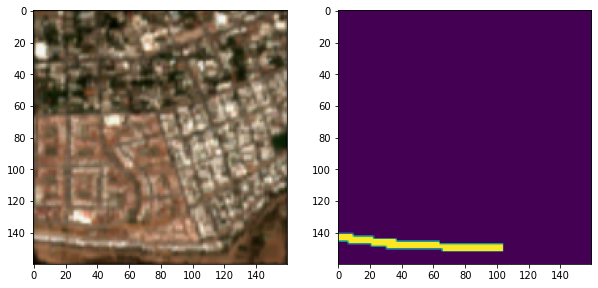

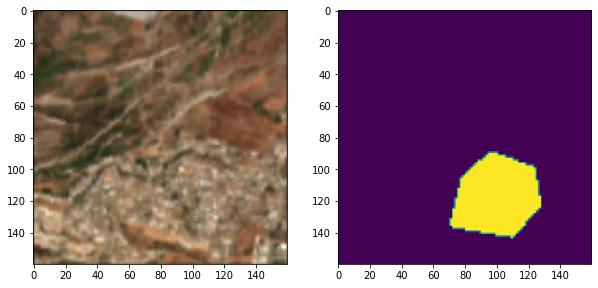

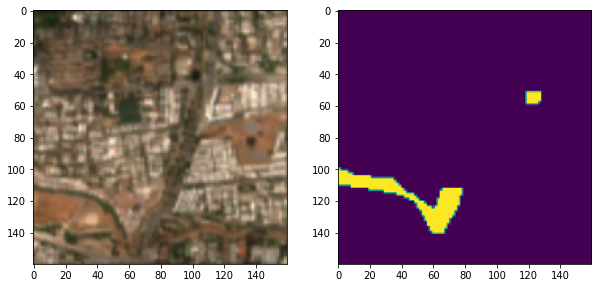

In [5]:
plot_data_generator(num_samples=3, fig_size=(10, 10), train_config = config,img_ch = 3)

### Entrenamiento

In [ ]:
#Se entrena el modelo con los parametros establecidos
res_config = train(config)

### Graficos Loss y Mean_iou de train-test

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_config.history['loss'])
plt.plot(res_config.history['val_loss'])
plt.title('Loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_config.history['mean_io_u'])
plt.plot(res_config.history['val_mean_io_u'])
plt.title('mean_iou')
plt.ylabel('val_mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.show()